# 使用订单簿数据：NASDAQ ITCH


市场数据的主要来源是订单簿，它全天实时不断更新以反映所有交易活动。交易所通常提供此数据作为实时服务，并可能免费提供一些历史数据。

交易活动反映在市场参与者发送的有关交易订单的大量消息中。这些消息通常符合用于实时交换证券交易和市场数据的电子金融信息交换 (FIX) 通信协议或本地交换协议。

## 背景

### FIX 协议

就像 SWIFT 是用于后台（例如，用于贸易结算）消息传递的消息协议一样，[FIX 协议](https://www.fixtrading.org/standards/) 是事实上的用于交易所、银行、经纪人、清算公司和其他市场参与者之间的交易执行消息的传递标准。 Fidelity Investments 和 Salomon Brothers 于 1992 年推出了 FIX，以促进经纪自营商和机构客户之间的电子通信，他们当时通过电话交换信息。

在扩展到外汇、固定收益和衍生品市场之前，它在全球股票市场变得流行，并在支持盘后交易的直通式处理。交易所提供对 FIX 消息的访问作为实时数据馈送，算法交易者解析该消息以跟踪市场活动，例如，识别市场参与者的足迹并预测他们的下一步行动。

### 纳斯达克 TotalView-ITCH 订单簿数据

虽然 FIX 占据着巨大的市场份额，但交易所也提供本地协议。纳斯达克提供 [TotalView ITCH 直接数据馈送协议](http://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHspecification.pdf)，允许订阅者跟踪从下达到执行或撤销单项权益工具指令。

因此，它允许重建跟踪特定证券或金融工具的主动限价买卖订单列表的订单簿。订单簿通过列出每个价位的出价或出价股票数量来揭示全天的市场深度。它还可以识别负责特定买卖订单的市场参与者，除非它是匿名下达的。市场深度是流动性和大量市场订单的潜在价格影响的关键指标。

ITCH v5.0 规范声明了 20 多种与系统事件、股票特征、限价单的下达和修改以及交易执行相关的消息类型。它还包含有关开盘价和收盘价交叉之前的净订单不平衡的信息。

## 导入库

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
%matplotlib inline
import gzip
import shutil
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [3]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>5.2f}'

In [4]:
format_time(time())

'468710:54:21.92'

## 从 FTP 服务器获取 NASDAQ ITCH 数据


纳斯达克提供几个月的每日二进制文件[样本](https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/) 。

我们现在将说明如何解析 ITCH 消息的示例文件并为任何给定的分时重建已执行的交易和订单簿。

数据相当大，运行整个示例可能会花费大量时间并需要大量内存 (16GB+)。此外，此示例中使用的示例文件可能不再可用，因为 NASDAQ 偶尔会更新示例文件。

下表显示了样本文件日期为 2018 年 3 月 29 日的最常见消息类型的频率：


| Name                    | Offset  | Length  | Value      | Notes                                                                                |
|-------------------------|---------|---------|------------|--------------------------------------------------------------------------------------|
| Message Type            | 0       | 1       | S          | System Event Message                                                                 |
| Stock Locate            | 1       | 2       | Integer    | Always 0                                                                             |
| Tracking Number         | 3       | 2       | Integer    | Nasdaq internal tracking number                                                      |
| Timestamp               | 5       | 6       | Integer    | Nanoseconds since midnight                                                           |
| Order Reference Number  | 11      | 8       | Integer    | The unique reference number assigned to the new order at the time of receipt.        |
| Buy/Sell Indicator      | 19      | 1       | Alpha      | The type of order being added. B = Buy Order. S = Sell Order.                        |
| Shares                  | 20      | 4       | Integer    | The total number of shares associated with the order being added to the book.        |
| Stock                   | 24      | 8       | Alpha      | Stock symbol, right padded with spaces                                               |
| Price                   | 32      | 4       | Price (4)  | The display price of the new order. Refer to Data Types for field processing notes.  |
| Attribution             | 36      | 4       | Alpha      | Nasdaq Market participant identifier associated with the entered order               |

### 设置数据路径

我们会将下载内容存储在“data”子目录中，并将结果转换为“hdf”格式（在第 2 章的最后一节中讨论）。


In [5]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'


您可以在 [纳斯达克服务器](https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/) 上找到几个示例文件。

此示例中使用的 HTTPS 地址、文件名和相应日期：

In [6]:
HTTPS_URL = 'https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/'
SOURCE_FILE = '10302019.NASDAQ_ITCH50.gz'

#### 网址更新

纳斯达克偶尔会更新文件，以便 SOURCE_FILE 发生变化。如果上面出现错误，请使用浏览器导航到 HTTPS_URL，并检查新文件。截至 2021 年 9 月，列出的文件包括：

- 01302020.NASDAQ_ITCH50.gz
- 12302019.NASDAQ_ITCH50.gz
- 10302019.NASDAQ_ITCH50.gz
- 08302019.NASDAQ_ITCH50.gz
- 07302019.NASDAQ_ITCH50.gz
- 03272019.NASDAQ_ITCH50.gz
- 01302019.NASDAQ_ITCH50.gz
- 12282018.NASDAQ_ITCH50.gz


### 下载并解压

In [7]:
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()
    else: 
        print('Directory exists')

    filename = data_path / url.split('/')[-1]        
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)
    else: 
        print('File exists')        

    unzipped = data_path / (filename.stem + '.bin')
    if not unzipped.exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else: 
        print('File already unpacked')
    return unzipped

这将下载 5.1GB 的数据，解压缩后为 12.9GB（这可能因文件而异，请参阅下面的“url 更新”）。


In [8]:
file_name = may_be_download(urljoin(HTTPS_URL, SOURCE_FILE))
date = file_name.name.split('.')[0]

Creating directory
Downloading... https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/10302019.NASDAQ_ITCH50.gz
Unzipping to data\10302019.NASDAQ_ITCH50.bin


## ITCH 格式设置

### 二进制数据的 `struct` 模块

ITCH 滴答数据采用二进制格式。 Python 提供了“struct”模块（参见 [docs](https://docs.python.org/3/library/struct.html)）来使用格式字符串解析二进制数据，格式字符串通过指示消息元素的长度和类型来识别消息元素规范中规定的字节串的各个组成部分。

官方文档描述：

> 该模块执行 Python 值和表示为 Python 字节对象的 C 结构之间的转换。这可用于处理存储在文件中或来自网络连接以及其他来源的二进制数据。它使用格式字符串作为 C 结构布局的紧凑描述以及与 Python 值的预期转换。

让我们来看看解析交易消息和重建订单簿的关键步骤：

### 定义格式字符串

解析器根据以下格式字典使用格式字符串：

In [5]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

In [6]:
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

In [7]:
formats = {
    ('integer', 2): 'H',  # int of length 2 => format string 'H'
    ('integer', 4): 'I',
    ('integer', 6): '6s',  # int of length 6 => parse as string, convert later
    ('integer', 8): 'Q',
    ('alpha',   1): 's',
    ('alpha',   2): '2s',
    ('alpha',   4): '4s',
    ('alpha',   8): '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

### 为二进制数据解析器创建消息规范

ITCH 解析器依赖于我们在以下步骤中创建的消息规范。

#### 加载消息类型

文件“message_types.xlxs”包含 [文档](https://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHSpecification.pdf) 中列出的消息类型规范

In [8]:
message_data = (pd.read_excel('message_types.xlsx',
                              sheet_name='messages')
                .sort_values('id')
                .drop('id', axis=1))

In [9]:
message_data.head()

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below


#### 基础数据清理

函数 clean_message_types() 只运行几个基本的字符串清理步骤。

In [10]:
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = df.value.str.strip()
    df.name = (df.name
               .str.strip() # remove whitespace
               .str.lower()
               .str.replace(' ', '_')
               .str.replace('-', '_')
               .str.replace('/', '_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

In [11]:
message_types = clean_message_types(message_data)

In [13]:
message_types.head()

,name,offset,length,value,notes,message_type
0,message_type,0,1,S,System Event Message,S
1,stock_locate,1,2,Integer,Always 0,NaN
2,tracking_number,3,2,Integer,Nasdaq internal tracking number,NaN
3,timestamp,5,6,Integer,Nanoseconds since midnight,NaN
4,event_code,11,1,Alpha,See System Event Codes below,NaN


In [16]:
message_types.dropna().head()

,name,offset,length,value,notes,message_type
0,message_type,0,1,S,System Event Message,S
5,message_type,0,1,R,Stock Directory Message,R
23,message_type,0,1,H,Stock Trading Action Message.,H
31,message_type,0,1,Y,Reg SHO Short Sale Price Test Restricted Indic...,Y
37,message_type,0,1,L,Market Participant Position message,L


#### 获取消息标签

我们提取消息类型代码和名称，以便稍后使结果更具可读性。

In [18]:
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.head()

,message_type,name
0,S,System Event Message
5,R,Stock Directory Message
23,H,Stock Trading Action Message.
31,Y,Reg SHO Short Sale Price Test Restricted Indic...
37,L,Market Participant Position message


In [19]:

message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
# message_labels.to_csv('message_labels.csv', index=False)
message_labels.head()

C:\Users\lipei\AppData\Local\Temp\ipykernel_6552\809292713.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  message_labels.name = (message_labels.name


,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


### 完成规范细节

每条消息都包含几个字段，这些字段由偏移量、长度和值类型定义。 `struct` 模块将使用此格式信息来解析二进制源数据。

In [20]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name != 'message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))
message_types.info()

C:\Users\lipei\AppData\Local\Temp\ipykernel_6552\2031385230.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  message_types.value = (message_types.value


<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


d:\miniconda3\envs\ml4t\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
message_types.head()

,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


可选,从文件中持久化/重新加载：


In [22]:
message_types.to_csv('message_types.csv', index=False)

In [23]:
message_types = pd.read_csv('message_types.csv')

In [24]:
message_types.head()

,name,offset,length,value,notes,message_type
0,stock_locate,1,2,integer,Always 0,S
1,tracking_number,3,2,integer,Nasdaq internal tracking number,S
2,timestamp,5,6,integer,Nanoseconds since midnight,S
3,event_code,11,1,alpha,See System Event Codes below,S
4,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


解析器将消息规范翻译成格式字符串和捕获消息内容的“namedtuples”。首先，我们根据 ITCH 规范创建“(type, length)”格式化元组：

In [26]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                            .apply(tuple, axis=1).map(formats))
message_types.head()

,name,offset,length,value,notes,message_type,formats
0,stock_locate,1,2,integer,Always 0,S,H
1,tracking_number,3,2,integer,Nasdaq internal tracking number,S,H
2,timestamp,5,6,integer,Nanoseconds since midnight,S,6s
3,event_code,11,1,alpha,See System Event Codes below,S,s
4,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R,H


然后，我们提取字母数字字段的格式详细信息

In [27]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_fields.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


In [28]:
alpha_msgs = alpha_fields.groupby('message_type')
alpha_msgs.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s
issue_classification,26,1,alpha,Identifies the security class for the issue as...,R,s
stock,11,8,alpha,"Stock symbol, right padded with spaces",H,8s
trading_state,19,1,alpha,Indicates the current trading state for the st...,H,s
reserved,20,1,alpha,Reserved.,H,s


In [29]:

alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

In [32]:
alpha_length

{'A': {'buy_sell_indicator': 6, 'stock': 13},
 'C': {'printable': 6},
 'F': {'buy_sell_indicator': 6, 'stock': 13, 'attribution': 9},
 'H': {'stock': 13, 'trading_state': 6, 'reserved': 6, 'reason': 9},
 'I': {'imbalance_direction': 6,
  'stock': 13,
  'cross_type': 6,
  'price_variation_indicator': 6},
 'J': {'stock': 13},
 'K': {'stock': 13, 'ipo_quotation_release_qualifier': 6},
 'L': {'mpid': 9,
  'stock': 13,
  'primary_market_maker': 6,
  'market_maker_mode': 6,
  'market_participant_state': 6},
 'P': {'buy_sell_indicator': 6, 'stock': 13},
 'Q': {'stock': 13, 'cross_type': 6},
 'R': {'stock': 13,
  'market_category': 6,
  'financial_status_indicator': 6,
  'round_lots_only': 6,
  'issue_classification': 6,
  'issue_sub_type': 7,
  'authenticity': 6,
  'short_sale_threshold_indicator': 6,
  'ipo_flag': 6,
  'luld_reference_price_tier': 6,
  'etp_flag': 6,
  'inverse_indicator': 6},
 'S': {'event_code': 6},
 'W': {'breached_level': 6},
 'Y': {'stock': 13, 'reg_sho_action': 6},
 'h

In [31]:
alpha_formats

{'A': {'buy_sell_indicator': 's', 'stock': '8s'},
 'C': {'printable': 's'},
 'F': {'buy_sell_indicator': 's', 'stock': '8s', 'attribution': '4s'},
 'H': {'stock': '8s', 'trading_state': 's', 'reserved': 's', 'reason': '4s'},
 'I': {'imbalance_direction': 's',
  'stock': '8s',
  'cross_type': 's',
  'price_variation_indicator': 's'},
 'J': {'stock': '8s'},
 'K': {'stock': '8s', 'ipo_quotation_release_qualifier': 's'},
 'L': {'mpid': '4s',
  'stock': '8s',
  'primary_market_maker': 's',
  'market_maker_mode': 's',
  'market_participant_state': 's'},
 'P': {'buy_sell_indicator': 's', 'stock': '8s'},
 'Q': {'stock': '8s', 'cross_type': 's'},
 'R': {'stock': '8s',
  'market_category': 's',
  'financial_status_indicator': 's',
  'round_lots_only': 's',
  'issue_classification': 's',
  'issue_sub_type': '2s',
  'authenticity': 's',
  'short_sale_threshold_indicator': 's',
  'ipo_flag': 's',
  'luld_reference_price_tier': 's',
  'etp_flag': 's',
  'inverse_indicator': 's'},
 'S': {'event_code'

我们将消息类生成为命名元组和格式字符串

In [33]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())

In [34]:
alpha_fields.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, event_code to price_variation_indicator
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   offset        45 non-null     int64 
 1   length        45 non-null     int64 
 2   value         45 non-null     object
 3   notes         45 non-null     object
 4   message_type  45 non-null     object
 5   formats       45 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB


In [35]:
alpha_fields.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


`alpha` 类型（字母数字）的字段需要按照 `format_alpha` 函数中的定义进行后处理：

In [29]:
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

## 处理二进制消息数据

一天的二进制文件包含超过 350,000,000 条消息，价值超过 12 GB。

In [31]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if m == 'R':
                dc.append('stock')
            try:
                store.append(mtype,
                         data,
                         format='t',
                         min_itemsize=s,
                         data_columns=dc)
            except Exception as e:
                print(e)
                print(mtype)
                print(data.info())
                print(pd.Series(list(m.keys())).value_counts())
                data.to_csv('data.csv', index=False)
                return 1
    return 0

In [32]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

该脚本使用我们刚刚定义的“store_messages()”函数将解析结果迭代地附加到快速 HDF5 格式的文件中，以避免内存限制（有关此格式的更多信息，请参阅第 2 章的最后一节）。

以下代码处理二进制文件并生成按消息类型存储的已解析订单：

In [33]:
start = time()
with file_name.open('rb') as data:
    while True:

        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)
        
        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')        
        message_type_counter.update([message_type])

        # read & store message
        try:
            record = data.read(message_size - 1)
            message = message_fields[message_type]._make(unpack(fstring[message_type], record))
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)
            print(record)
            print(fstring[message_type])
        
        # deal with system events
        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break
        message_count += 1

        if message_count % 2.5e7 == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
            res = store_messages(messages)
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

print('Duration:', format_time(time() - start))


 Start of Messages
	03:02:31.65	           0

 Start of System Hours
	04:00:00.00	     241,258

 Start of Market Hours
	09:30:00.00	   9,559,279
	09:44:09.23	  25,000,000	00:02:00.01
	10:07:45.15	  50,000,000	00:06:27.97
	10:39:56.24	  75,000,000	00:10:42.61
	11:18:09.64	 100,000,000	00:15:08.06
	11:58:35.35	 125,000,000	00:19:12.22
	12:44:20.61	 150,000,000	00:23:24.43
	13:41:03.75	 175,000,000	00:27:46.48
	14:18:44.52	 200,000,000	00:32:05.49
	14:49:19.38	 225,000,000	00:36:31.14
	15:19:40.72	 250,000,000	00:41:10.22
	15:50:23.01	 275,000,000	00:47:31.80

 End of Market Hours
	16:00:00.00	 290,920,164

 End of System Hours
	20:00:00.00	 293,944,863

 End of Messages
	20:05:00.00	 293,989,078
Duration: 00:59:13.21


## 交易日总结

### 交易消息频率

In [34]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
counter

,Message Type,# Trades
A,add_order_no_mpid_attribution,127214649
D,order_delete,123296742
U,order_replace,25513651
E,order_executed,7316703
I,noii,3740140
X,order_cancel,3568735
P,trade,1525363
F,add_order_mpid_attribution,1423908
L,market_participant_position,214865
C,order_executed_with_price,129729


In [35]:
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)

### 成交额最高的股票

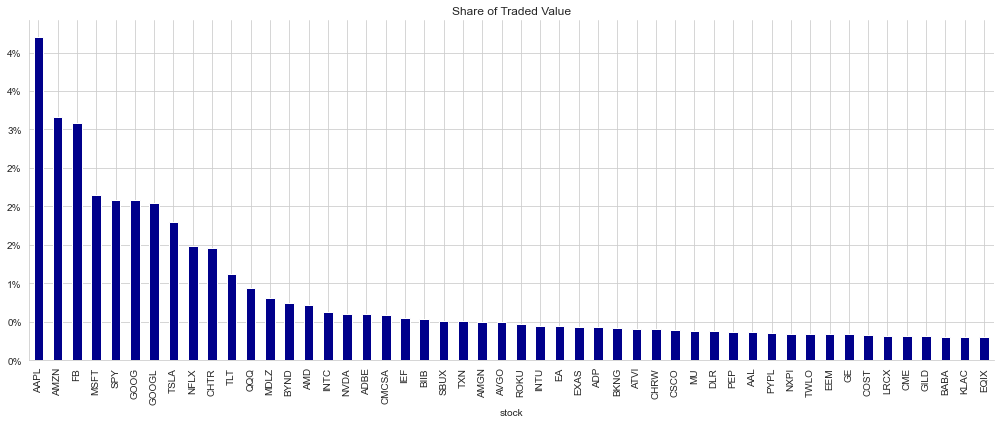

In [36]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()